# Cleaning files to match the format

In [6]:
import os
import re

# Define the folder containing the text files
folder_path = "../files/data/FA7000-15-D-0006-0016/CASE24_KI_Single_Cracks"

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # print(filename)
    
    # Read the file content
    with open(file_path, 'r') as file:
        global constant_value
        global thickness_value
        global radius_value
        content = file.readlines()
        line = content[1]
        values = line.strip().split()
        if values[0] == "Geometry:":
            # Extract the constant multiplying thickness
            constant_match = re.search(r'Width=Height=(\d+)\*thickness', line)
            constant_value = int(constant_match.group(1)) if constant_match else None
            # print("Const: ", constant_value)

            # Extract the thickness value
            thickness_match = re.search(r'Thickness=\s*([\d.]+)', line)
            thickness_value = float(thickness_match.group(1)) if thickness_match else None
            # print("Thickness: ", thickness_value)

            # Extract the radius value
            radius_match = re.search(r'Hole radius:\s*([\d.]+)', line)
            radius_value = float(radius_match.group(1)) if radius_match else None
            # print("Radius: ", radius_value)
        else:
            print("Something is wrong with: ", filename)

        W = constant_value*thickness_value
        W_R = W / radius_value

    
    # Modify lines that start with "Results for crack number:"
    updated_content = []
    for line in content:
        if line.startswith("Results for crack number:"):
            # Add "W/R=[W_R]," after "Results for"
            updated_line = re.sub(
                r"(Results for )",
                rf"\1W/R = {W_R}, ",
                line
            )
            updated_content.append(updated_line)
        else:
            updated_content.append(line)
    
    # Write the updated content back to the file
    with open(file_path, 'w') as file:
        file.writelines(updated_content)

print("Modification completed!")

Modification completed!


# Dependencies

In [7]:
import numpy as np
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator

from tqdm import tqdm

# Working on...

In [8]:
# Specify the directory path
dir_path = "../files/data/"

# Get folder names
master_folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

print(master_folders)

['FA7000-15-D-0006-19FA202', 'BH_SINGLE', 'FA700021D0002-23F0143', 'FA7000-15-D-0006-0016', 'FA7000-15-D-0006-9011', 'FA700021D0002-22F0214', 'FA7000-15-D-0006-20F0212']


In [9]:
master_folder = master_folders[3]

# Specify the directory path
dir_path = "../files/data/{}".format(master_folder)

# Get folder names
folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

print(folders)

['CASE24_KI_Single_Cracks']


# .DAT to .csv

In [10]:
def process_file(file_info):
    input_file_path, output_file_path = file_info
    
    rows = []
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        W_R = None
        a_c, a_t, r_t, b_t = None, None, None, None
        crack = False

        for i, line in enumerate(lines):
            values = line.strip().split()
            if not values:
                continue

            if values[0] == "Results":
                W_R = float(values[4][:-1])

            elif values[0] == "ndom":
                crack = False
                next_values = lines[i + 1].strip().split()
                a_c, a_t, r_t, b_t = map(float, next_values[1:5])

            elif values[0] == "crack":
                crack = True

            elif values[0].isdigit() and crack:
                row = [W_R, a_c, a_t, r_t, b_t] + list(map(float, values[6:10]))
                rows.append(row)

    df = pd.DataFrame(rows, columns=['W/R', 'a/c', 'a/t', 'r/t', 'b/t', 'phi', 'K-T', 'K-B', 'K-P'])
    df.to_csv(output_file_path, index=False)

tasks = []

for folder in folders:
    dir_path = os.path.join("../files/data", master_folder, folder)
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

    for file_name in files:
        input_file_path = os.path.join(dir_path, file_name)
        output_file_path = os.path.join(dir_path, f"{file_name[:-4]}.csv")
        tasks.append((input_file_path, output_file_path))

# Process files in parallel
with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(process_file, tasks), total=len(tasks), desc="Processing Files"))
    # executor.map(process_file, tasks)


Processing Files: 100%|██████████| 36/36 [00:55<00:00,  1.54s/it]


# One .csv for each b/t

In [11]:
for folder in folders:
    # Specify the directory path
    dir_path = "../files/data/{}/{}".format(master_folder, folder)

    # Get all .csv files
    csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

    print(csv_files)

    df = pd.read_csv("../files/data/{}/{}/{}".format(master_folder, folder, csv_files[0]))
    # df = df.drop(columns=["b/t"])
    df = df.drop(df[df['phi'] == 0].index)
    df = df.drop(df[df['K-T'] == 0].index)
    df = df.drop(df[df['K-B'] == 0].index)
    df = df.drop(df[df['K-P'] == 0].index)
    df.dropna(inplace=True)

    for index in csv_files[1:]:
        df_ = pd.read_csv("../files/data/{}/{}/{}".format(master_folder, folder, index))
        # df_ = df_.drop(columns=["b/t"])
        df_ = df_.drop(df_[df_['phi'] == 0].index)
        df_ = df_.drop(df_[df_['K-T'] == 0].index)
        df_ = df_.drop(df_[df_['K-B'] == 0].index)
        df_ = df_.drop(df_[df_['K-P'] == 0].index)
        df_.dropna(inplace=True)
        df = pd.concat([df, df_], axis=0, ignore_index=True)

    df.to_csv("../files/data/{}/{}.csv".format(master_folder, folder), index=False)

['CASE12_SINGLE_Rt-0d5-bt-1dot0.DATA-uni.csv', 'CASE27_SINGLE_Rt-5d0-bt-1dot0.DATA-.csv', 'CASE32_SINGLE_Rt-10d0-bt-1dot0.DATA-.csv', 'CASE22_SINGLE_Rt-2d0-bt-1dot0.DATA-uni.csv', 'CASE13_SINGLE_Rt-0d5714-bt-1dot0.DATA-.csv', 'CASE25_SINGLE_Rt-3d0-bt-1dot0.DATA-Garnet-uni.csv', 'CASE21_SINGLE_Rt-1d75-bt-1dot0.DATA-.csv', 'CASE4_SINGLE_Rt-0d125-bt-1dot0.DATA-.csv', 'CASE22_SINGLE_Rt-2d0-bt-1dot0.DATA-.csv', 'CASE16_SINGLE_Rt-0d8-bt-1dot0.DATA-.csv', 'CASE12_SINGLE_Rt-0d5-bt-1dot0.DATA-.csv', 'CASE24_SINGLE_Rt-2d5-bt-1dot0.DATA-.csv', 'CASE3_SINGLE_Rt-0d111-bt-1dot0.DATA-.csv', 'CASE30_SINGLE_Rt-8d0-bt-1dot0.DATA-.csv', 'CASE14_SINGLE_Rt-0d667-bt-1dot0.DATA-.csv', 'CASE19_SINGLE_Rt-1d333-bt-1dot0.DATA-.csv', 'CASE7_SINGLE_Rt-0d2-bt-1dot0.DATA-.csv', 'CASE20_SINGLE_Rt-1d5-bt-1dot0.DATA-uni.csv', 'CASE24_SINGLE_Rt-2d5-bt-1dot0.DATA-uni.csv', 'CASE2_SINGLE_Rt-0d1-bt-1dot0.DATA-.csv', 'CASE17_SINGLE_Rt-1d0-bt-1dot0.DATA-.csv', 'CASE28_SINGLE_Rt-6d0-bt-1dot0.DATA-.csv', 'CASE25_SINGLE_Rt-3d0-

# Viz each .csv

In [12]:
# Specify the directory path
dir_path = "../files/data/{}".format(master_folder)

# Get all .csv files
csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

print(csv_files)

['CASE24_KI_Single_Cracks.csv']


Working On: CASE24_KI_Single_Cracks.csv
Different combinations:  15073

Different W/r values:  [  10.      11.111   12.5     16.667   20.      25.      33.333   40.
   44.444   50.      57.143   66.667   75.019   80.     100.     125.
  133.333  149.925  175.009  200.     225.023  250.     300.3    400.
  500.     599.88   700.28   800.     900.901 1000.   ]
Different a/c values:  [ 0.1     0.111   0.125   0.1428  0.1667  0.2     0.25    0.333   0.5
  0.667   0.75    0.8     1.      1.25    1.333   1.5     2.      3.
  4.      5.      6.      7.      8.      9.     10.    ]
Different a/t values:  [ 0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   0.95  1.05  1.15
  1.25  1.5   1.75  2.    2.5   3.    4.    5.    6.    8.   10.  ]
Different r/t values:  [ 0.1     0.111   0.125   0.1428  0.1667  0.2     0.25    0.333   0.4
  0.4444  0.5     0.5714  0.667   0.75    0.8     1.      1.25    1.333
  1.5     1.75    2.      2.25    2.5     3.      4.      5.      6.
  8.      9.     10. 

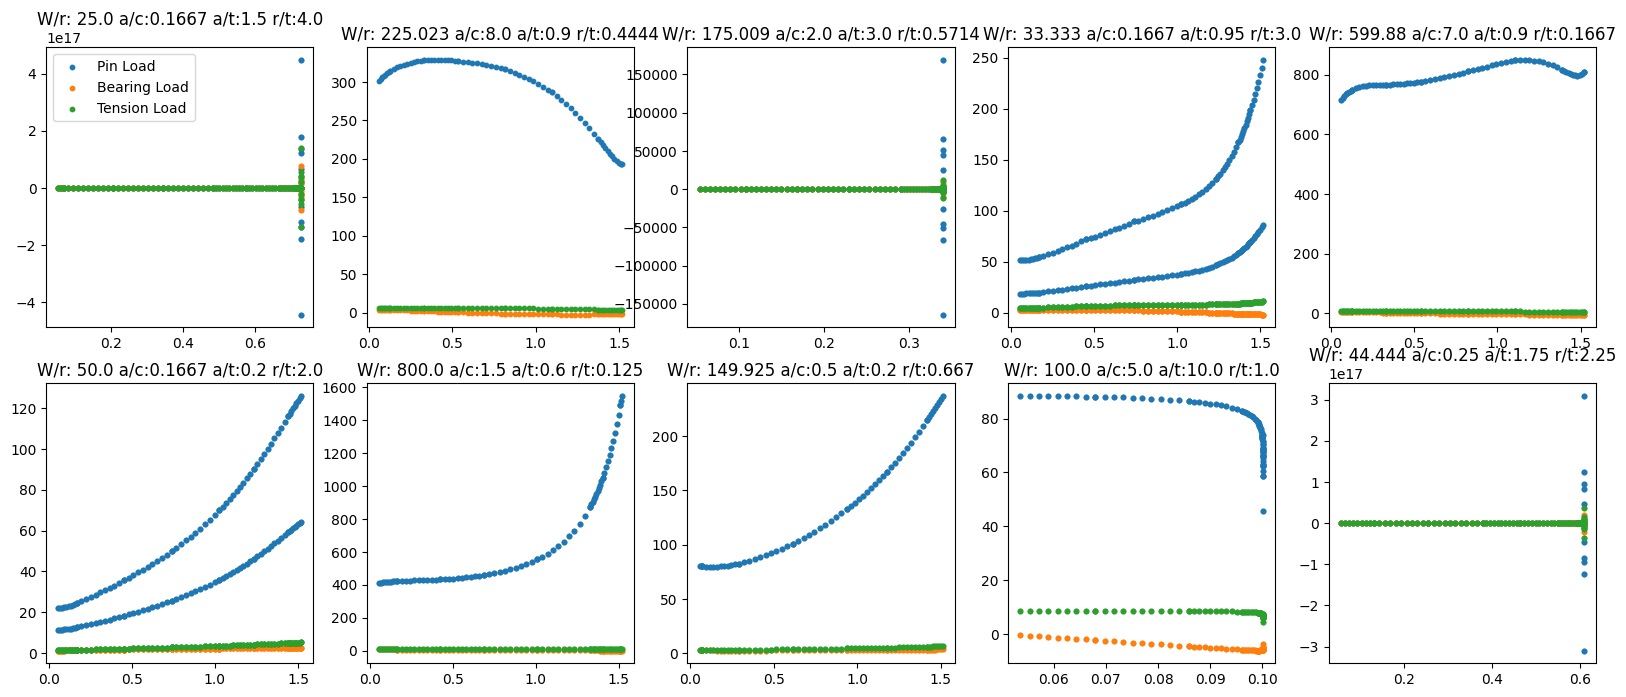

In [13]:
for file in csv_files:
    print("========================")
    print("Working On: {}".format(file))
    print("========================")
    df = pd.read_csv("../files/data/{}/{}".format(master_folder, file))
    d = df.to_numpy()

    # Getting all a/c, a/t and c/b combinations
    CC_combinations = [d[0,:5]]

    for line in d:
        if (line[:5] == CC_combinations[-1]).all():
            continue
        else:
            CC_combinations.append(line[:5])

    CC_combinations = np.unique(CC_combinations, axis=0)

    print("Different combinations: ", len(CC_combinations))
    
    print("")

    print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
    print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
    print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
    print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
    print("Different b/t values: ", np.unique(CC_combinations[:,4], axis=0))

    np.random.seed(0)
    fig, axs = plt.subplots(2, 5, figsize=(20,8))
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, len(CC_combinations))
            combination = CC_combinations[idx]
            indices = np.where((d[:, 0] == combination[0]) & 
                            (d[:, 1] == combination[1]) &
                            (d[:, 2] == combination[2]) &
                            (d[:, 3] == combination[3]) &
                            (d[:, -4] >= np.max(np.unique(0.052))) & 
                            (d[:, -4] <= np.min(np.unique(1.52))))
            indices = indices[0]
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-1], label="Pin Load", s=10)
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-2], label="Bearing Load", s=10)
            axs[i,j].scatter(d[indices][:,-4], d[indices][:,-3], label="Tension Load", s=10)
            axs[i,j].set_title("W/r: {} a/c:{} a/t:{} r/t:{}".format(combination[0], combination[1], combination[2], combination[3]))
            
            if i == 0 and j == 0:
                axs[i,j].legend()
    plt.show()